# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [1]:
import os
import sys
import random
import warnings
import numpy as np

seed = 42 # for reproduction
random.seed(seed)
np.random.seed(seed)

import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

/home/peter/virtual_envs/tf_keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [3]:
from skimage.measure import regionprops
import cv2, imutils
import math

# Get and resize train images and masks
X_train = []
Y_train = []
#lsum = 0
#msum = 0
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    X_train.append(img)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mark = np.zeros(img.shape[:2], dtype=np.uint8)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        cnts = cv2.findContours(mask_.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if imutils.is_cv2() else cnts[1]
        M = cv2.moments(cnts[0])
        if M["m00"] != 0:
            cX = M["m10"] / M["m00"]
            cY = M["m01"] / M["m00"]
        else:
            p = regionprops(mask_, cache=True)[0]
            cY, cX = p.centroid
        r = int(math.ceil( max( img.shape[0], img.shape[1] ) * .01 ))
        cv2.circle(mark, (int(cX), int(cY)), r, 255, -1)
        mask = np.maximum(mask, mask_)
    mark = cv2.GaussianBlur(mark, (3,3), 0)
    #lsum += np.sum(mask)
    #msum += np.sum(mark)
    Y_train.append([mask, mark])

# print(msum / (lsum+msum))

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append(img.shape[:2])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:22<00:00,  8.15it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 28.56it/s]

Done!


Let's see if things look all right by drawing some random images and their associated masks.

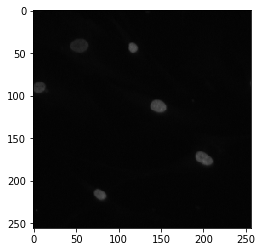

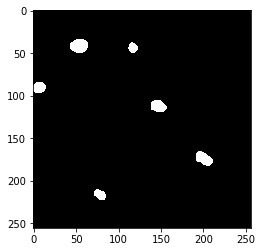

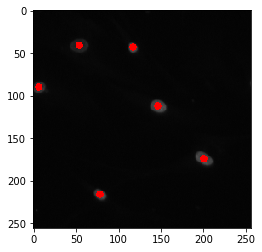

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix][0]), cmap='gray')
plt.show()
x_copy = X_train[ix].copy()
x_copy[np.squeeze(Y_train[ix][1])>0, :] = 255, 0, 0
plt.imshow(x_copy)
plt.show()

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

In [5]:
# Define IoU metric
def mean_iou(y_true_, y_pred_):
    y_true = y_true_[...,0]
    y_pred = y_pred_[...,0]
    prec = []
    for t in np.arange(0.5, 1.0, 0.1):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def mean_iou_marker(y_true_, y_pred_):
    y_true = y_true_[...,1]
    y_pred = y_pred_[...,1]
    prec = []
    for t in np.arange(0.5, 1.0, 0.1):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.*intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + intersection + smooth)

from keras.losses import binary_crossentropy

def custom_loss(y_true_, y_pred_):
    alpha = 0.8 # control amount of loss of markers
    
    y_true_hm = y_true_[...,0]
    y_true_mk = y_true_[...,1]
    
    y_pred_hm = y_pred_[...,0]
    y_pred_mk = y_pred_[...,1]
    
    s_marker_loss = .5 * binary_crossentropy(y_true_mk, y_pred_mk) - dice_coef(y_true_mk, y_pred_mk)
    s_heatmap_loss= .5 * binary_crossentropy(y_true_hm, y_pred_hm) - dice_coef(y_true_hm, y_pred_hm)
    
    losses = alpha * s_marker_loss + (1.-alpha) * s_heatmap_loss
    return losses

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [6]:
from keras.layers import Lambda, Add, Activation, UpSampling2D, Dropout
from keras.optimizers import Adam

def build_stage(inputs, last=None, id_='st1'):
    def conv(f, k=3, act='elu'):
        return Conv2D(f, (k, k), activation=act, kernel_initializer='he_normal', padding='same')
    def _incept_conv(inputs, f, dropout=0, chs=[0.15, 0.5, 0.25, 0.1]):
        fs = [] # determine channel number
        for k in chs:
            t = max(int(k*f), 1) # at least 1 channel
            fs.append(t)
        
        fs[1] += f-np.sum(fs) # reminding channels allocate to 3x3 conv
        
        c1x1 = conv(fs[0], 1, act='linear') (inputs)
        c3x3 = conv(max(1, fs[1]//2), 1, act='elu') (inputs)
        c5x5 = conv(max(1, fs[2]//2), 1, act='elu') (inputs)
        cpool= MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same') (inputs)
        
        c3x3 = conv(fs[1], 3, act='linear') (c3x3)
        c5x5 = conv(fs[2], 5, act='linear') (c5x5)
        cpool= conv(fs[3], 1, act='linear') (cpool)
        
        output = concatenate([c1x1, c3x3, c5x5, cpool], axis=-1)
        if dropout>0:
            output = Dropout(dropout) (output)
        return output
    
    def _res_conv(inputs, f, k=3, dropout=0.1): # very simple residual module
        channels = int(inputs.shape[-1])
        
        cs = _incept_conv(inputs, f, dropout=dropout)
        
        if f!=channels:
            t1 = conv(f, 1, 'linear') (inputs) # identity mapping
        else:
            t1 = inputs
        
        out = Add()([t1, cs]) # t1 + c2
        out = Activation('elu') (out)
        return out
    def pool():
        return MaxPooling2D((2, 2))
    def up(inputs, dropout=0):
        upsampled = Conv2DTranspose(int(inputs.shape[-1]), (2, 2), strides=(2, 2), padding='same') (inputs)
        if dropout>0:
            upsampled = Dropout(dropout) (upsampled)
        return upsampled
    
    if last is None:
        c1 = Lambda(lambda x: x / 255) (inputs) # 1st stage input, an image
    else:
        c1 = Add()([inputs, last]) # dimensions of inputs, last are same
    
    c1 = _res_conv(c1, 32, 3)
    o1 = c1
    p1 = pool() (c1)
    
    c2 = _res_conv(p1, 64, 3)
    p2 = pool() (c2)

    c3 = _res_conv(p2, 128, 3)
    p3 = pool() (c3)
    
    c4 = _res_conv(p3, 256, 3)
    p4 = pool() (c4)
    
    c5 = _res_conv(p4, 512, 3)
    p5 = pool() (c5)
    
    c6 = _res_conv(p5, 512, 3, dropout=0.3)
    
    u7 = up (c6, dropout=0.3)
    c7 = concatenate([u7, c5])
    c7 = _res_conv(c7, 512, 3)
    
    u8 = up (c7, dropout=0.25)
    c8 = concatenate([u8, c4])
    c8 = _res_conv(c8, 256, 3)
    
    u9 = up (c8, dropout=0.2)
    c9 = concatenate([u9, c3])
    c9 = _res_conv(c9, 128, 3)
    
    u10 = up (c9, dropout=0.14)
    c10 = concatenate([u10, c2])
    c10 = _res_conv(c10, 64, 3)
    
    u11 = up (c10, dropout=0.1)
    c11 = concatenate([u11, c1])
    c11 = _res_conv(c11, 32, 3)
    
    outputs = Conv2D(2, (1, 1), activation='sigmoid', name=id_+'_out') (c11)
    return outputs, o1

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
out, _ = build_stage(inputs, None, 'st1')

model = Model(inputs=[inputs], outputs=[out])
model.compile(loss=custom_loss, metrics=[mean_iou, mean_iou_marker], optimizer='adam')
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  32          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 4)  16          lambda_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [7]:
from keras.preprocessing.image import ImageDataGenerator
import cv2

from sklearn.utils import shuffle
def data_generator(data, label, batch_size=4, training=True):
    index = 0
    dat_que = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    lab_que = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH, 2), dtype=np.bool)
    while True:
        img = data[index%len(data)] # [0,255]
        lab = label[index%len(data)][0]
        marker = label[index%len(data)][1]
        if training:
            if np.random.rand() < .5: # flip vertical
                img = np.flip(img, 0)
                lab = np.flip(lab, 0)
                marker = np.flip(marker, 0)
            if np.random.rand() < .5: # flip horizontal
                img = np.flip(img, 1)
                lab = np.flip(lab, 1)
                marker = np.flip(marker, 1)

            # rotation
            if np.random.rand() < 0.5:
                y, x, _ = img.shape
                h, w = y, x
                img = cv2.copyMakeBorder(img, y//2, y//2, x//2, x//2, cv2.BORDER_REFLECT)
                lab = cv2.copyMakeBorder(lab, y//2, y//2, x//2, x//2, cv2.BORDER_REFLECT)
                marker = cv2.copyMakeBorder(marker, y//2, y//2, x//2, x//2, cv2.BORDER_REFLECT)
                y, x, _ = img.shape
                rotT = np.random.uniform(-15,15)
                M = cv2.getRotationMatrix2D((x/2, y/2), rotT, 1)
                img = cv2.warpAffine(img, M, (x, y))
                lab = cv2.warpAffine(lab, M, (x, y))
                marker = cv2.warpAffine(marker, M, (x, y))
                img = img[h//2:h//2+h,w//2:w//2+w,:]
                lab = lab[h//2:h//2+h,w//2:w//2+w]
                marker = marker[h//2:h//2+h,w//2:w//2+w]

            img = img.astype(np.float32) / 255. # normalize

            # random amplify each channel
            a = .1 # amptitude
            t  = [np.random.uniform(-a,a)]
            t += [np.random.uniform(-a,a)]
            t += [np.random.uniform(-a,a)]
            t = np.array(t)

            img = img * (1. + t) # channel wise amplify
            up = np.random.uniform(0.95, 1.05) # change gamma
            img = img**up * 255. # apply gamma and convert back to range [0,255]
            img = img.astype(np.uint8) # convert back to uint8

            assert img.dtype == np.uint8 ## check type
            assert lab.dtype == np.uint8

            if np.random.rand() < .1: # randomly crop image
                s = np.random.uniform(0.8, 1.2) # random crop scale
                w, h = int(s*IMG_WIDTH), int(s*IMG_HEIGHT)
                paddx = max(0, w-img.shape[1])
                paddy = max(0, h-img.shape[0])
                img = cv2.copyMakeBorder(img, paddy//2, paddy-paddy//2, paddx//2, paddx-paddx//2, cv2.BORDER_REFLECT)
                lab = cv2.copyMakeBorder(lab, paddy//2, paddy-paddy//2, paddx//2, paddx-paddx//2, cv2.BORDER_REFLECT)
                marker = cv2.copyMakeBorder(marker, paddy//2, paddy-paddy//2, paddx//2, paddx-paddx//2, cv2.BORDER_REFLECT)
                cropx = img.shape[1] - w + 1
                cropy = img.shape[0] - h + 1
                offx = np.random.randint(0, cropx)
                offy = np.random.randint(0, cropy)
                img = img[offy:offy+h, offx:offx+w, :]
                lab = lab[offy:offy+h, offx:offx+w]
                marker = marker[offy:offy+h, offx:offx+w]
        ### end of data augmentation ###
        
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        lab = resize(lab, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        marker = resize(marker, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        
        lab[lab<130] = 0
        lab[lab>0] = 1
        
        marker[marker<130] = 0
        marker[marker>0] = 1
        
        dat_que[index%batch_size,:,:,:] = img
        lab_que[index%batch_size,:,:,0] = lab
        lab_que[index%batch_size,:,:,1] = marker
        index = index + 1
        if index%batch_size==0:
            index = 0 if index%len(data)==0 else index
            yield (dat_que, lab_que)
        if training and index%len(data)==0:
            data, label = shuffle(data, label)

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True)

# Fit model
BS=8
EPOCHS=120

os.makedirs('./models', exist_ok=True)

# earlystopper = EarlyStopping(patience=7, verbose=1)
checkpointer = ModelCheckpoint('./models/model.{epoch:03d}.vl.{val_loss:.2f}.vi.{val_mean_iou:.2f}.vim.{val_mean_iou_marker:.2f}.h5', verbose=1, save_best_only=False)
history = model.fit_generator(data_generator(X_train, Y_train, batch_size=BS, training=True),
                              steps_per_epoch=len(X_train) // BS , epochs=EPOCHS, 
                              validation_data=data_generator(X_val, Y_val, batch_size=BS, training=False), 
                              validation_steps=len(X_val) // BS,
                             callbacks=[checkpointer])

Epoch 1/120
74/75 [============================>.] - ETA: 1s - loss: -0.1235 - mean_iou: 0.4664 - mean_iou_marker: 0.4930
Epoch 00001: saving model to ./models/model.001.vl.-0.27.vi.0.56.vim.0.55.h5
75/75 [==============================] - 92s 1s/step - loss: -0.1244 - mean_iou: 0.4676 - mean_iou_marker: 0.4936 - val_loss: -0.2720 - val_mean_iou: 0.5623 - val_mean_iou_marker: 0.5456
Epoch 2/120
74/75 [============================>.] - ETA: 0s - loss: -0.3294 - mean_iou: 0.6145 - mean_iou_marker: 0.5705
Epoch 00002: saving model to ./models/model.002.vl.-0.35.vi.0.66.vim.0.59.h5
75/75 [==============================] - 65s 868ms/step - loss: -0.3299 - mean_iou: 0.6151 - mean_iou_marker: 0.5707 - val_loss: -0.3486 - val_mean_iou: 0.6581 - val_mean_iou_marker: 0.5868
Epoch 3/120
74/75 [============================>.] - ETA: 0s - loss: -0.3663 - mean_iou: 0.6875 - mean_iou_marker: 0.5995
Epoch 00003: saving model to ./models/model.003.vl.-0.39.vi.0.71.vim.0.61.h5
75/75 [===================

74/75 [============================>.] - ETA: 0s - loss: -0.4711 - mean_iou: 0.8449 - mean_iou_marker: 0.6970
Epoch 00022: saving model to ./models/model.022.vl.-0.48.vi.0.85.vim.0.70.h5
75/75 [==============================] - 74s 983ms/step - loss: -0.4710 - mean_iou: 0.8449 - mean_iou_marker: 0.6970 - val_loss: -0.4754 - val_mean_iou: 0.8457 - val_mean_iou_marker: 0.6976
Epoch 23/120
74/75 [============================>.] - ETA: 0s - loss: -0.4731 - mean_iou: 0.8465 - mean_iou_marker: 0.6983
Epoch 00023: saving model to ./models/model.023.vl.-0.48.vi.0.85.vim.0.70.h5
75/75 [==============================] - 76s 1s/step - loss: -0.4733 - mean_iou: 0.8465 - mean_iou_marker: 0.6984 - val_loss: -0.4785 - val_mean_iou: 0.8473 - val_mean_iou_marker: 0.6991
Epoch 24/120
74/75 [============================>.] - ETA: 0s - loss: -0.4727 - mean_iou: 0.8480 - mean_iou_marker: 0.6997
Epoch 00024: saving model to ./models/model.024.vl.-0.50.vi.0.85.vim.0.70.h5
75/75 [=============================

74/75 [============================>.] - ETA: 0s - loss: -0.4879 - mean_iou: 0.8651 - mean_iou_marker: 0.7175
Epoch 00043: saving model to ./models/model.043.vl.-0.51.vi.0.87.vim.0.72.h5
75/75 [==============================] - 73s 971ms/step - loss: -0.4877 - mean_iou: 0.8651 - mean_iou_marker: 0.7175 - val_loss: -0.5121 - val_mean_iou: 0.8655 - val_mean_iou_marker: 0.7178
Epoch 44/120
74/75 [============================>.] - ETA: 0s - loss: -0.4884 - mean_iou: 0.8657 - mean_iou_marker: 0.7181
Epoch 00044: saving model to ./models/model.044.vl.-0.51.vi.0.87.vim.0.72.h5
75/75 [==============================] - 71s 945ms/step - loss: -0.4889 - mean_iou: 0.8657 - mean_iou_marker: 0.7181 - val_loss: -0.5063 - val_mean_iou: 0.8660 - val_mean_iou_marker: 0.7186
Epoch 45/120
74/75 [============================>.] - ETA: 0s - loss: -0.4915 - mean_iou: 0.8663 - mean_iou_marker: 0.7189
Epoch 00045: saving model to ./models/model.045.vl.-0.50.vi.0.87.vim.0.72.h5
75/75 [==========================

74/75 [============================>.] - ETA: 0s - loss: -0.4925 - mean_iou: 0.8749 - mean_iou_marker: 0.7297
Epoch 00064: saving model to ./models/model.064.vl.-0.51.vi.0.88.vim.0.73.h5
75/75 [==============================] - 71s 944ms/step - loss: -0.4917 - mean_iou: 0.8749 - mean_iou_marker: 0.7297 - val_loss: -0.5057 - val_mean_iou: 0.8751 - val_mean_iou_marker: 0.7298
Epoch 65/120
74/75 [============================>.] - ETA: 0s - loss: -0.5000 - mean_iou: 0.8752 - mean_iou_marker: 0.7301
Epoch 00065: saving model to ./models/model.065.vl.-0.52.vi.0.88.vim.0.73.h5
75/75 [==============================] - 75s 1s/step - loss: -0.5002 - mean_iou: 0.8752 - mean_iou_marker: 0.7301 - val_loss: -0.5214 - val_mean_iou: 0.8754 - val_mean_iou_marker: 0.7303
Epoch 66/120
74/75 [============================>.] - ETA: 0s - loss: -0.5017 - mean_iou: 0.8756 - mean_iou_marker: 0.7305
Epoch 00066: saving model to ./models/model.066.vl.-0.50.vi.0.88.vim.0.73.h5
75/75 [=============================

74/75 [============================>.] - ETA: 0s - loss: -0.5025 - mean_iou: 0.8807 - mean_iou_marker: 0.7376
Epoch 00085: saving model to ./models/model.085.vl.-0.53.vi.0.88.vim.0.74.h5
75/75 [==============================] - 71s 945ms/step - loss: -0.5021 - mean_iou: 0.8807 - mean_iou_marker: 0.7376 - val_loss: -0.5306 - val_mean_iou: 0.8808 - val_mean_iou_marker: 0.7377
Epoch 86/120
74/75 [============================>.] - ETA: 0s - loss: -0.5080 - mean_iou: 0.8809 - mean_iou_marker: 0.7380
Epoch 00086: saving model to ./models/model.086.vl.-0.52.vi.0.88.vim.0.74.h5
75/75 [==============================] - 75s 1s/step - loss: -0.5082 - mean_iou: 0.8809 - mean_iou_marker: 0.7380 - val_loss: -0.5193 - val_mean_iou: 0.8810 - val_mean_iou_marker: 0.7381
Epoch 87/120
74/75 [============================>.] - ETA: 0s - loss: -0.5095 - mean_iou: 0.8811 - mean_iou_marker: 0.7383
Epoch 00087: saving model to ./models/model.087.vl.-0.54.vi.0.88.vim.0.74.h5
75/75 [=============================

74/75 [============================>.] - ETA: 0s - loss: -0.5152 - mean_iou: 0.8848 - mean_iou_marker: 0.7439
Epoch 00106: saving model to ./models/model.106.vl.-0.56.vi.0.88.vim.0.74.h5
75/75 [==============================] - 71s 943ms/step - loss: -0.5153 - mean_iou: 0.8848 - mean_iou_marker: 0.7439 - val_loss: -0.5571 - val_mean_iou: 0.8849 - val_mean_iou_marker: 0.7441
Epoch 107/120
74/75 [============================>.] - ETA: 0s - loss: -0.5066 - mean_iou: 0.8850 - mean_iou_marker: 0.7442
Epoch 00107: saving model to ./models/model.107.vl.-0.55.vi.0.89.vim.0.74.h5
75/75 [==============================] - 71s 952ms/step - loss: -0.5065 - mean_iou: 0.8850 - mean_iou_marker: 0.7442 - val_loss: -0.5547 - val_mean_iou: 0.8851 - val_mean_iou_marker: 0.7443
Epoch 108/120
74/75 [============================>.] - ETA: 0s - loss: -0.5039 - mean_iou: 0.8852 - mean_iou_marker: 0.7444
Epoch 00108: saving model to ./models/model.108.vl.-0.54.vi.0.89.vim.0.74.h5
75/75 [========================

In [8]:
model.save('model.h5')

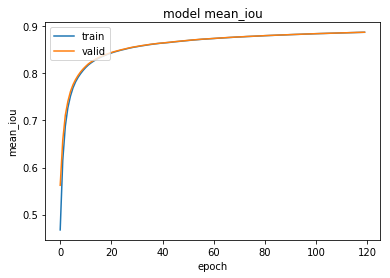

In [9]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model mean_iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

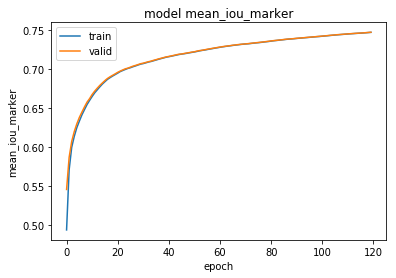

In [10]:
plt.plot(history.history['mean_iou_marker'])
plt.plot(history.history['val_mean_iou_marker'])
plt.title('model mean_iou_marker')
plt.ylabel('mean_iou_marker')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

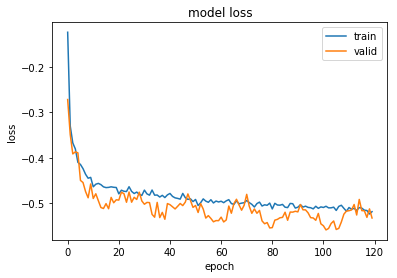

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [12]:
from skimage.morphology import closing, square, remove_small_objects
from skimage.segmentation import clear_border

# Predict on train, val and test
# model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou, 'custom_loss': custom_loss, 'mean_iou_marker': mean_iou_marker, 'dice_coef': dice_coef})
preds_train = model.predict_generator(data_generator(X_train, Y_train, batch_size=1, training=False), steps=len(X_train), verbose=1)
preds_val = model.predict_generator(data_generator(X_val, Y_val, batch_size=1, training=False), steps=len(X_val), verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train, preds_train_marker = preds_train[...,0], preds_train[...,1]
preds_val, preds_val_marker = preds_val[...,0], preds_val[...,1]
preds_test, preds_test_marker = preds_test[...,0], preds_test[...,1]

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_train_marker_t = (preds_train_marker > 0.5).astype(np.uint8)
preds_val_marker_t = (preds_val_marker > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append((resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True),
                                 resize(np.squeeze(preds_test_marker[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True)
                                ))

65/65 [==============================] - 1s 22ms/step


In [13]:
from scipy import ndimage as ndi
from skimage.morphology import watershed

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def lb(image, marker):
    if np.sum(image) < np.sum(marker):
        image = marker
    else:
        marker = np.array((marker==1) & (image==1))
    distance = ndi.distance_transform_edt(image)
    markers = ndi.label(marker)[0]
    labels = watershed(-distance, markers, mask=image)
    if np.sum(labels) == 0:
        labels[0,0] = 1
    return labels

def prob_to_rles(x, marker, cutoff=0.5, cutoff_marker=0.5):
    lab_img = lb(x > cutoff, marker > cutoff_marker)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

114


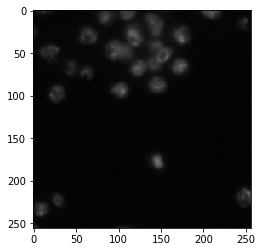

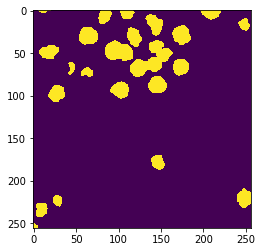

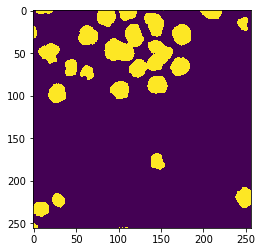

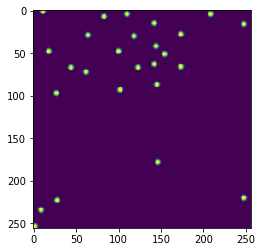

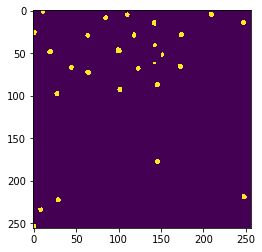

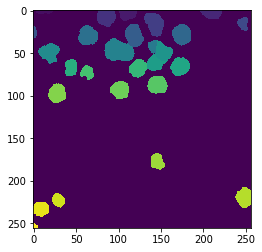

In [14]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
print(ix)
shape = Y_train[ix][0].shape[:2]
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix][0]))
plt.show()
plt.imshow(resize(np.squeeze(preds_train_t[ix]), shape))
plt.show()
plt.imshow(np.squeeze(Y_train[ix][1]))
plt.show()
plt.imshow(resize(np.squeeze(preds_train_marker_t[ix]), shape))
plt.show()
lab = lb(preds_train_t[ix], preds_train_marker_t[ix])
plt.imshow(lab)
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

31


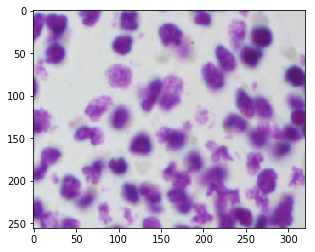

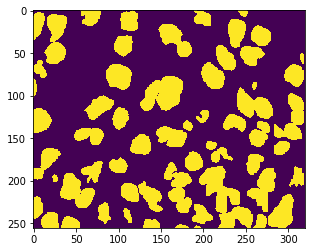

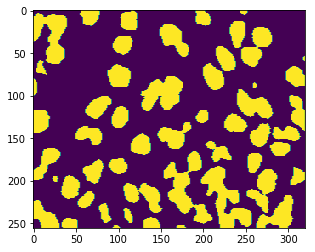

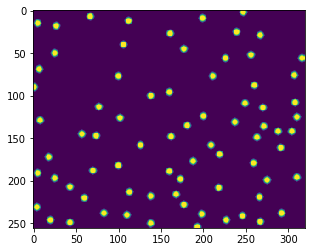

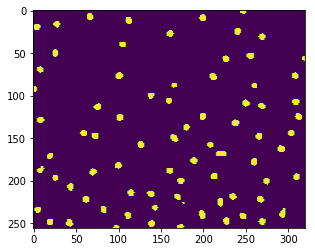

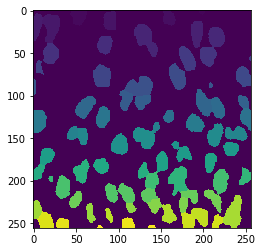

In [20]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
print(ix)
shape = Y_val[ix][0].shape[:2]
plt.imshow(X_val[ix])
plt.show()
plt.imshow(np.squeeze(Y_val[ix][0]))
plt.show()
plt.imshow(resize(np.squeeze(preds_val_t[ix]), shape))
plt.show()
plt.imshow(np.squeeze(Y_val[ix][1]))
plt.show()
plt.imshow(resize(np.squeeze(preds_val_marker_t[ix]), shape))
plt.show()
lab = lb(preds_val_t[ix], preds_val_marker_t[ix])
plt.imshow(lab)
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [16]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n][0], preds_test_upsampled[n][1]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [17]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)